In [1]:
from MDP import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from math import floor

In [2]:
# Create the gridworld, and set cell values to equal rewards
print('(Creating Willemsen Gridworld)')
grid = np.ones((3, 9)) * -1
grid[1,:8] = 0
grid[1, 8] = 1
grid[2, :8] = 0
terminal_state = []
for i in [0,2]:
    for j in range(8):
        terminal_state.append([i,j])
terminal_state.append([1,8])
terminal_state = np.array(terminal_state)
initial_state = np.array([1, 0])
blacked_state = np.array([[0, 8],[2, 8]])

# fig, ax, im, cb = plot_gridworld(grid, terminal_state, initial_state, blacked_state, fig=None, ax=None, show=True)

(Creating Willemsen Gridworld)


In [3]:
n_episodes = 100
max_steps = 1000
episode_timeout = 40
gamma = 0.8
alpha = 0.1
n_batches = 1

EXPLORATION_TYPE = 'PHASED'

if EXPLORATION_TYPE == 'RANDOM':
    epsilons = np.ones(n_episodes)
elif EXPLORATION_TYPE == 'GRADUAL':
    epsilons = np.flip(np.linspace(0.05, 1, n_episodes))
elif EXPLORATION_TYPE == 'GREEDY':
    epsilons = np.zeros(n_episodes)
elif EXPLORATION_TYPE == 'GLOBAL':
    epsilons = np.ones(n_episodes)
elif EXPLORATION_TYPE == "PHASED":
    epsilons = np.zeros(n_episodes)

Learn = True
batch_size = 10
FILE_SIG = f"Results_n={n_episodes}, nB={batch_size}, exp={EXPLORATION_TYPE} WG, N_init_1"


env = Gridworld(grid, terminal_state, initial_state, blacked_state, episode_timeout)
env_greedy = Gridworld(grid, terminal_state, initial_state, blacked_state, episode_timeout)

## Batch Run Exploration followed by Exploitation

In [17]:
M = []
for n in tqdm(range(n_batches)):
    agent = Greedy(estimators = [Estimator(approximator=bellman_RMax(alpha=0.1, gamma=0.8), mask=identity())],
                    buffer = ReplayMemory(max_size=10000),
                    targets = [Target()],
                    counter = state_table(),
                    batch_size=batch_size)
    
    trajectories = []
    metrics = []
    epilen = []
    Gn = []
    step = 0
    while step < max_steps:
        # set action selection to be explorative: "novelty"
        agent.action_selection = "novelty"
        agent.train = True
        action = agent.select_action(env.transition)
        transition = env.step(action)
        agent.observe(transition)
        Gn.append(transition.reward)

        # set action selection to be exploitative: "greedy"
        agent.action_selection = "greedy"
        agent.train = False
        agent.epsilon = 0
        Gg = []
        
        # set greedy env to the arrival state of the last transition
        env_greedy.reset()

        while not env_greedy.terminal and not env_greedy.timeout:
            action = agent.select_action(env_greedy.transition)
            transition = env_greedy.step(action)
            Gg.append(transition.reward)

        step += 1

        metrics.append({
            'Q': dict(agent.estimators[0].approximator.table), 
            'V': dict(agent.counter.table),
            'U': dict(agent.estimators[0].visits),
            'Gn': Gn,
            'Gg': Gg,
            'steps': step
            })
        
        if env.terminal or env.timeout:
            trajectories.append(agent.trajectory)
            epilen.append([len(agent.trajectory), len(Gg)])
            
            env.reset()
            agent.reset_trajectory()
            Gn = []
            
    M.append(metrics)

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
x = np.arange(0, M[0][-1]['steps'])
yn = []
yg = []
for i, metrics in enumerate(M[0]):
    Yn = 0
    Yg = 0
    for j, g in enumerate(metrics['Gn']):
        Yn += gamma**j*g
    for j, g in enumerate(metrics['Gg']):
        Yg += gamma**j*g
    
    yn.append(Yn)
    yg.append(Yg)

In [19]:
cumEpilen = np.cumsum([ele[0] for ele in epilen])
cumEpiG = np.cumsum([ele[1] for ele in epilen])

<IPython.core.display.Javascript object>


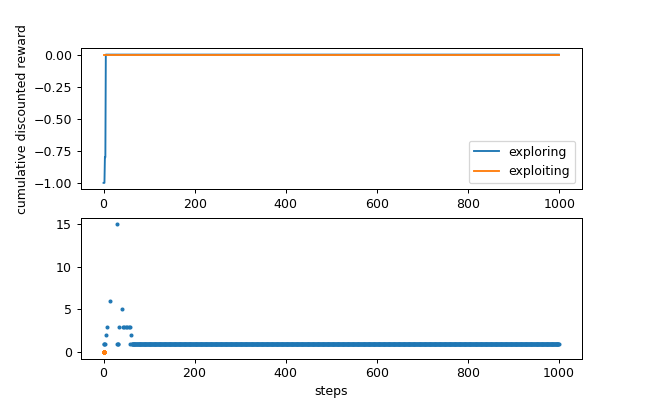

In [20]:
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,5))
ax1.plot(x, yn, label='exploring')

ax1.plot(x, yg, label='exploiting')

ax1.set_ylabel('cumulative discounted reward')
plt.xlabel('steps')

ax1.legend()

ax2.scatter(cumEpilen, [ele[0] for ele in epilen], s=5)
ax2.scatter(cumEpiG, [ele[1] for ele in epilen], s=5)

## Empirical Bootstrap Code

In [5]:
# percentile based on
# http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html

# adapted according to empirical on
# https://github.com/LizaLebedeva/bootstrap-experiments/blob/master/bootstrap_methods.ipynb

def bootstrap_empirical(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    obs_metric = func(data) # compute CI center from data directly
#     simulations = simulations - obs_metric # now move bootstrap to differences
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        percentile_upper = simulations[l_indx]
        percentile_lower = simulations[u_indx]
        empirical_lower = 2*obs_metric - percentile_lower
        empirical_upper = 2*obs_metric - percentile_upper
        return(empirical_lower,empirical_upper)
    return(ci)

In [6]:
Rn = np.zeros((n_batches, n_episodes))
Rg = np.zeros((n_batches, n_episodes))

x = []
steps = []

for i, batch in enumerate(M):
    for j, metrics in enumerate(batch):
        for exp, g in enumerate(metrics['Gn']):
            Rn[i,j] += gamma**exp*g
        for exp, g in enumerate(metrics['Gg']):
            Rg[i,j] += gamma**exp*g
    if i == 0:
        x.append(metrics['steps'])
    else:
        x.append(x[i-1]+metrics['steps'])
    steps.append(metrics['steps'])

In [7]:
yn = np.mean(Rn, axis=0)
yg = np.mean(Rg, axis=0)
ynCI = list(map(lambda p: bootstrap_empirical(p)(0.95), Rn.T))
ygCI = list(map(lambda p: bootstrap_empirical(p)(0.95), Rg.T))
Yn = np.transpose(ynCI)
Yg = np.transpose(ygCI)

<IPython.core.display.Javascript object>


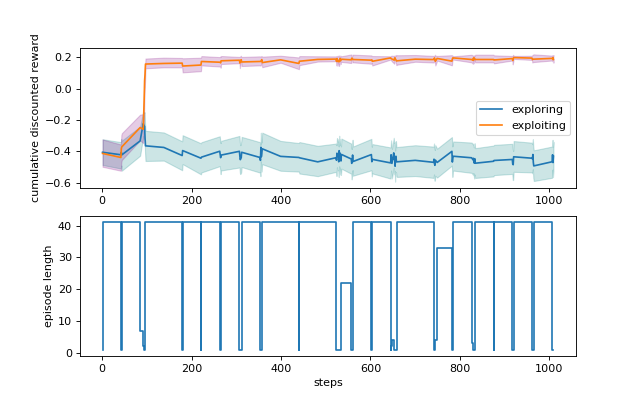

In [10]:
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,5))
ax1.plot(x, yn, label='exploring')
ax1.fill_between(x, Yn[0], Yn[1], color='teal', alpha=.2)

ax1.plot(x, yg, label='exploiting')
ax1.fill_between(x, Yg[0], Yg[1], color='purple', alpha=.2)

ax2.step(x, steps)
# plt.plot([100 for i in range(10)], np.linspace(np.min(Y), np.max(Y), 10), ls='--', color='black', label='greedy threshold')
ax1.set_ylabel('cumulative discounted reward')
ax2.set_ylabel('episode length')
plt.xlabel('steps')

ax1.legend()

In [9]:
trajectories

[[T((1, 0),right)-->(1, 1)), T((1, 1),up)-->(0, 1))],
 [T((1, 0),left)-->(1, 0)), T((1, 0),up)-->(0, 0))],
 [T((1, 0),up)-->(0, 0))],
 [T((1, 0),up)-->(0, 0))],
 [T((1, 0),up)-->(0, 0))],
 [T((1, 0),right)-->(1, 1)), T((1, 1),up)-->(0, 1))],
 [T((1, 0),up)-->(0, 0))],
 [T((1, 0),down)-->(2, 0))],
 [T((1, 0),up)-->(0, 0))],
 [T((1, 0),right)-->(1, 1)),
  T((1, 1),left)-->(1, 0)),
  T((1, 0),right)-->(1, 1)),
  T((1, 1),left)-->(1, 0)),
  T((1, 0),down)-->(2, 0))],
 [T((1, 0),up)-->(0, 0))],
 [T((1, 0),right)-->(1, 1)), T((1, 1),down)-->(2, 1))],
 [T((1, 0),down)-->(2, 0))],
 [T((1, 0),down)-->(2, 0))],
 [T((1, 0),left)-->(1, 0)), T((1, 0),down)-->(2, 0))],
 [T((1, 0),up)-->(0, 0))],
 [T((1, 0),left)-->(1, 0)),
  T((1, 0),left)-->(1, 0)),
  T((1, 0),left)-->(1, 0)),
  T((1, 0),left)-->(1, 0)),
  T((1, 0),left)-->(1, 0)),
  T((1, 0),left)-->(1, 0)),
  T((1, 0),left)-->(1, 0)),
  T((1, 0),left)-->(1, 0)),
  T((1, 0),left)-->(1, 0)),
  T((1, 0),left)-->(1, 0)),
  T((1, 0),left)-->(1, 0)),
 

## Batch Run with fewer episodes

In [58]:
n_exploratory_episodes = 5
n_greedy_episodes = 10
max_steps = 40
gamma = 0.8
alpha = 0.1
n_batches = 100

EXPLORATION_TYPE = 'PHASED'

if EXPLORATION_TYPE == 'RANDOM':
    epsilons = np.ones(n_episodes)
elif EXPLORATION_TYPE == 'GRADUAL':
    epsilons = np.flip(np.linspace(0.05, 1, n_episodes))
elif EXPLORATION_TYPE == 'GREEDY':
    epsilons = np.zeros(n_episodes)
elif EXPLORATION_TYPE == 'GLOBAL':
    epsilons = np.ones(n_episodes)
elif EXPLORATION_TYPE == "PHASED":
    epsilons = np.zeros(n_episodes)

Learn = True
batch_size = 1
FILE_SIG = f"Results_n={n_episodes}, nB={batch_size}, exp={EXPLORATION_TYPE} WG, N_init_1"


env = Gridworld(grid, terminal_state, initial_state, blacked_state, max_steps)

In [59]:
M = []
for n in range(n_batches):
    agent = GlobalNoveltor(estimators = [Estimator(approximator=bQt_novel_alpha(gamma=0.8), mask=identity()), 
                               Estimator(approximator=bellman_N_table(alpha=0.1, gamma=0.8), mask=identity()),
                               Estimator(global_N_abstractor(alpha=0.1, gamma=0.8), mask=global_context()),
                               Estimator(global_Q_abstractor(gamma=0.8), mask=global_context())],
                    buffer = ReplayMemory(max_size=10000),
                    targets = [Target()],
                    counter = state_table(),
                    batch_size=batch_size)
    
    # set action selection to be explorative: "novelty"
    agent.action_selection = "novelty"

    trajectories = []
    metrics = []
    for i in tqdm(range(n_exploratory_episodes)):
        trajectory, G = run_trajectory(env, agent, epsilons[i], abstract=False)

        trajectories.append(trajectory)

        metrics.append({
            'Q': dict(agent.estimators[0].approximator.table), 
            'N': dict(agent.estimators[1].approximator.table),
            'Na': dict(agent.estimators[2].approximator.evaluate(0)),
            'Qa': dict(agent.estimators[3].approximator.evaluate(0)),
            'V': dict(agent.counter.table),
            'U': dict(agent.estimators[0].visits),
            'G': G
            })
        
    # set action selection to be exploitative: "greedy"
    agent.action_selection = "greedy"

    for i in tqdm(range(n_greedy_episodes)):
        trajectory, G = run_trajectory(env, agent, epsilons[i], abstract=False)

        trajectories.append(trajectory)

        metrics.append({
            'Q': dict(agent.estimators[0].approximator.table), 
            'N': dict(agent.estimators[1].approximator.table),
            'Na': dict(agent.estimators[2].approximator.evaluate(0)),
            'Qa': dict(agent.estimators[3].approximator.evaluate(0)),
            'V': dict(agent.counter.table),
            'U': dict(agent.estimators[0].visits),
            'G': G
            })
    
    M.append(metrics)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [60]:
R = np.zeros((n_batches, n_exploratory_episodes+n_greedy_episodes))

for i, batch in enumerate(M):
    for j, metrics in enumerate(batch):
        for exp, g in enumerate(metrics['G']):
            R[i,j] += gamma**exp*g

In [61]:
y = np.mean(R, axis=0)
yCI = list(map(lambda p: bootstrap_empirical(p)(0.95), R.T))
Y = np.transpose(yCI)

<IPython.core.display.Javascript object>


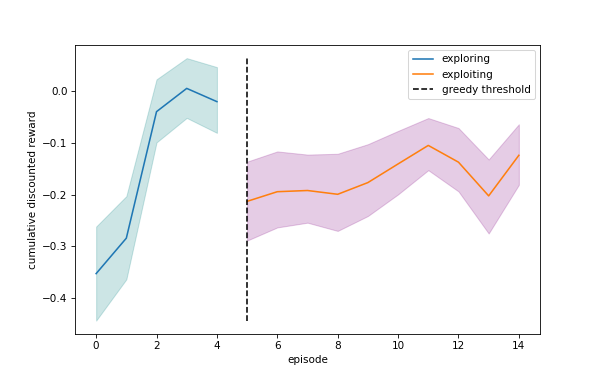

In [62]:
%matplotlib notebook
x1 = np.arange(0, n_exploratory_episodes, 1)
x2 = np.arange(n_exploratory_episodes, n_exploratory_episodes+n_greedy_episodes, 1)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(x1, y[:n_exploratory_episodes], label='exploring')
ax.fill_between(x1, Y[0,:n_exploratory_episodes], Y[1,:n_exploratory_episodes], color='teal', alpha=.2)

plt.plot(x2, y[n_exploratory_episodes:], label='exploiting')
ax.fill_between(x2, Y[0,n_exploratory_episodes:], Y[1,n_exploratory_episodes:], color='purple', alpha=.2)


plt.plot([n_exploratory_episodes for i in range(10)], np.linspace(np.min(Y), np.max(Y), 10), ls='--', color='black', label='greedy threshold')
plt.ylabel('cumulative discounted reward')
plt.xlabel('episode')

plt.legend()